In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Email Marketing Model

#### Problem Description:
You have to advise the CMO at an e-commerce startup doing $5M in yearly sales. The CMO sells
clothes and accessories via a web store and also on Amazon. They want to build a model that helps
them to predict how many orders they will get from email campaigns that they send.
<br>
<br>
They have some information available about the campaigns they are sending. They send emails at various
times of the day, to audiences who are more or less engaged and with various discount sizes.


#### Data definitions:
1. delivered - # of unique customers emailed as part of the campaign
2. opened - # of customers who opened the delivered emails
3. clicked - # of customers who clicked the buy product link in the email
4. Campaign sent period - what time of day the email was sent<br>
    a. 0 = morning<br>
    b. 1 = afternoon<br>
    c. 2 = evening<br>
5. Engagement score - average of days since a customer last purchased
6. Discount - the size of discount offered in the email
7. orders - # of unique customers who placed an order

## 1. In the practical world, data is often not clean. Can you identify some data errors and ways to handle them?

In [2]:
filename = 'C:/Users/17813/campaign_data.csv'
df = pd.read_csv(filename)
df.head()

,campaignid,delivered,opened,clicked,campaign_sent_period,avg_days_since_last_purchased,percent_discount_offered,orders
0,1,70,28,0,1,58,0.0,0
1,2,593202,103976,2071,1,25,0.0,117
2,3,24693,2532,43,1,15,0.0,5
3,4,3377,971,22,0,2,0.0,2
4,5,329913,101421,1680,0,4,0.5,166


In [3]:
df.shape

(499999, 8)

In [4]:
#check if any rows contain missing data
df[df.isnull().any(axis=1)]

,campaignid,delivered,opened,clicked,campaign_sent_period,avg_days_since_last_purchased,percent_discount_offered,orders


There are no missing values in the dataset.

In [5]:
df.describe()

,campaignid,delivered,opened,clicked,campaign_sent_period,avg_days_since_last_purchased,percent_discount_offered,orders
count,499999.00000,4.999990e+05,4.999990e+05,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000
mean,250000.00000,7.498530e+04,9.574928e+03,228.270941,0.969116,29.974146,0.021984,20.362495
std,144337.42296,3.212294e+05,3.129466e+04,941.674132,0.791594,22.481651,0.275857,94.687727
min,1.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000
25%,125000.50000,4.834000e+03,7.880000e+02,10.000000,0.000000,15.000000,0.000000,1.000000
50%,250000.00000,1.990600e+04,2.912000e+03,47.000000,1.000000,22.000000,0.000000,4.000000
75%,374999.50000,6.493800e+04,8.838000e+03,176.000000,2.000000,55.000000,0.000000,14.000000
max,499999.00000,1.559867e+07,1.397644e+06,118143.000000,2.000000,65.000000,49.500000,11411.000000


### percent_discount_offered variable

Looking at the summary statistics of each variable, I noticed that the percent_discount_offered variable has a maximum value of 49.5 and a value of 0.5 in campaignid 5. This could either be an error, or on purpose based on how the discounts are set up. Usually I would assume that the value .5 would represent a 50% discount, but seeing the value 49.5 means the .5 value can represent a 0.5% discount. To handle this in a real situation, I would reach out to the appropriate people who are responsible for setting up the campaigns and verify how this field should be interpreted. There could be a chance that there was actually a campaign that offered a 0.5% discount and another campaign that offered a 49.5% discount. If we find out that there weren't any campaigns with a 0.5% discount and should represent a 50% discount, then I would also need to verify with them if the 49.5 value if it was an error, or if it should be recorded as .495 in the dataset.

In [6]:
df[df['percent_discount_offered'] >= 1]['percent_discount_offered'].describe()

count    3593.000000
mean        1.949903
std         2.510334
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        49.500000
Name: percent_discount_offered, dtype: float64

There are multiple ways this can be handled if these values are an error:
- Can discard all rows where the 'percent_discount_offered' value is greater than or equal to 1.
- Can set all values in the 'percent_discount_offered' that are greater than or equal to 1 as NaN values and then then impute the values using the following approaches:
    1. mean or median value
    2. regression
    3. regression with perturbation
- Can reach out to other parties in the company that may have more knowledge to gain a better understanding of these data errors. If there is full certainty that these values should be set as decimals, divide these values by 100. If there is any uncertainty, do not use this approach.

I will now plot histograms for the numerical variables and a barplot for the categorical variable.

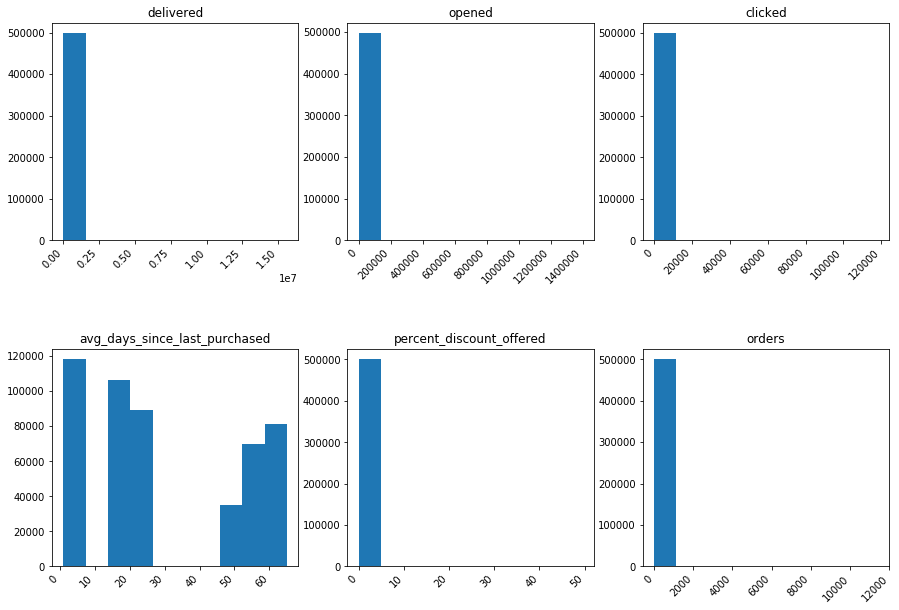

In [7]:
#plot histograms for all numerical variables
numerical_vars = ['delivered','opened','clicked','avg_days_since_last_purchased','percent_discount_offered','orders']

plt.figure(figsize=(15,10))

for i in enumerate(numerical_vars):
    plt.subplot(2, 3, i[0] + 1)
    plt.hist(df[i[1]])
    plt.gca().set_title(i[1])
    plt.xticks(rotation=45, ha='right')
    
plt.subplots_adjust(hspace=.5)

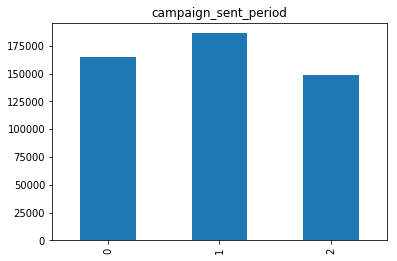

In [8]:
#plot barplot for categorical variable
df['campaign_sent_period'].value_counts().sort_index().plot(kind='bar');
plt.title('campaign_sent_period');

The campaign_sent_period variable does not seem to have anything off about it.
<br>
<br>
There are extremely long tails for the 'delivered', 'opened', 'clicked', 'percent_discount_offered', and 'orders' variables which is causing the histograms to only show 1 bar. Let's take a look at the boxplots of the numerical variables.

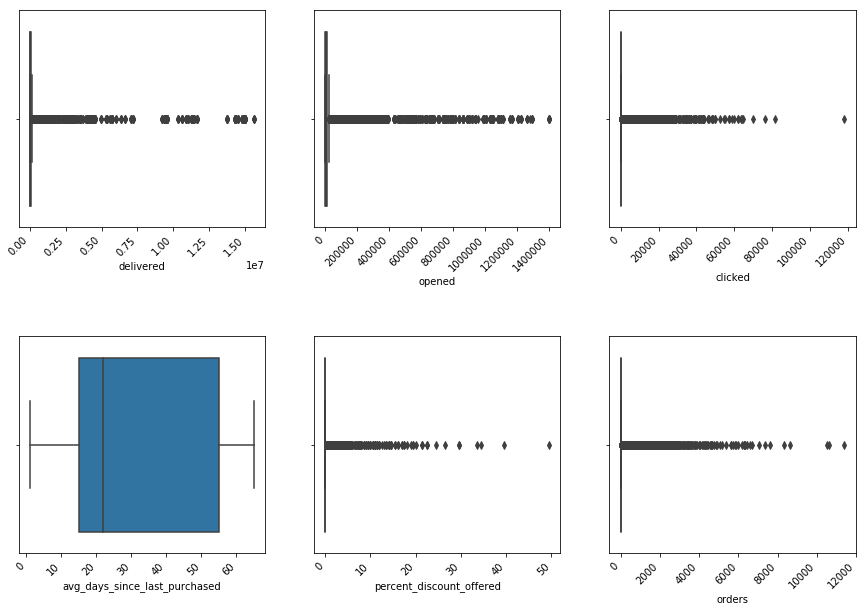

In [9]:
#plot boxplots for numerical variables
plt.figure(figsize=(15,10))

for i in enumerate(numerical_vars):
    plt.subplot(2, 3, i[0] + 1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation=45, ha='right')
    
plt.subplots_adjust(hspace=.5)

There are many larger values on the upper tail for the 'delivered', 'opened', 'clicked', and 'orders' variables that are considered as outliers by the boxplot. The outliers in the 'percent_discount_offered' are the values that are greater than 1. <br>
<br>
These values can either be outliers due to error, or outliers that are actually happening in reality. To deal with these outliers, I would most likely try to gain more context on why these values are so much higher compared to the others and understand the impact of keeping them in the dataset vs. removing them. To find this out, I would reach out to others in the company that may have more knowledge on the underlying reason for the outliers. For example, I would want to know if there was really 118143 clicks for one campaign that was very successful, or was this due to something like a computer program causing all of these clicks. It could turn out that these outliers were one time occurrances and would never happen again. In this case, it would make sense to remove them because it would affect the prediction of the model if we train the data with things that are one time occurrances. <br>
<br>
If these outliers have a chance of happening again in the future, then it might be okay to keep them in the dataset because we want to account for these occurrances. Before using the data, I would most likely perform a transformation to try to reduce the skewness in these variables to improve the model's prediction quality. Possible transformations I can use are:
- natural logarithmic transformation
- square root transformation
- box-cox transformation.

I will replot the histograms using the numerical variables after a log transformation.

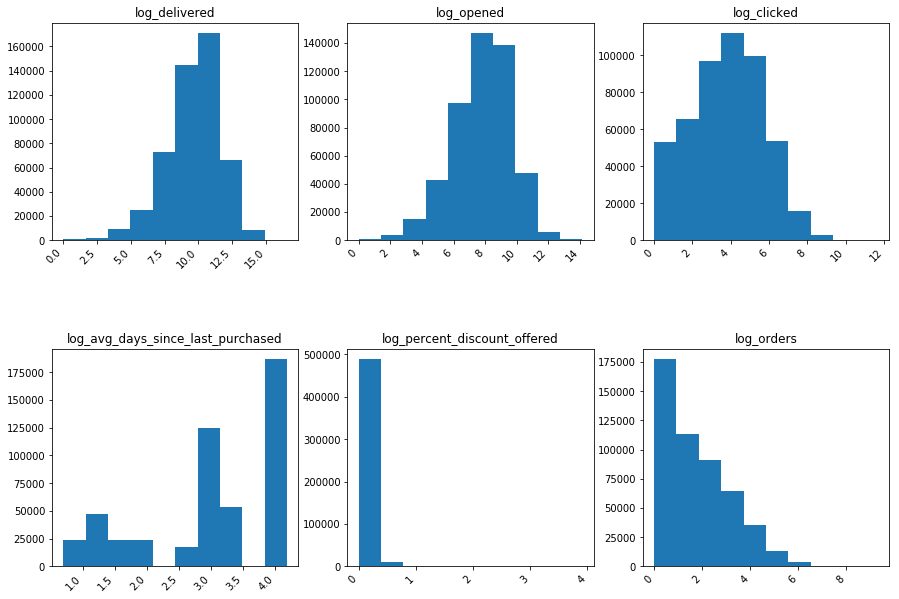

In [10]:
plt.figure(figsize=(15,10))

for i in enumerate(numerical_vars):
    plt.subplot(2, 3, i[0] + 1)
    plt.hist(np.log1p(df[i[1]]))
    plt.gca().set_title('log_' + i[1])
    plt.xticks(rotation=45, ha='right')
    
plt.subplots_adjust(hspace=.5)

Looking at the histograms above, he variables 'delivered', 'opened', 'clicked', and 'orders' are somewhat more evenly distributed after performing a log transformation. I will use the log transformed versions of these variables for the model.

In [11]:
#perform logarithmic transformation on specified columns
df['log_delivered'] = np.log1p(df['delivered'])
df['log_opened'] = np.log1p(df['opened'])
df['log_clicked'] = np.log1p(df['clicked'])
df['log_orders'] = np.log1p(df['orders'])

## 2. Code a linear model to predict the number of orders a campaign will generate. Why or why not would you choose to include certain factors that are available? How would you evaluate the accuracy of your model?

There are some variables in the dataset that are not independent from each other. This will affect the prediction quality of the linear model due to multicollinearity. To solve for this, we will need to exclude variables that are highly correlated with eachother.<br>
<br>
For example, the 'opened' variable is directly dependent on the 'delivered' variable. The 'clicked' variable can also be viewd as dependent on the 'delivered' variable. 

<Figure size 432x288 with 0 Axes>

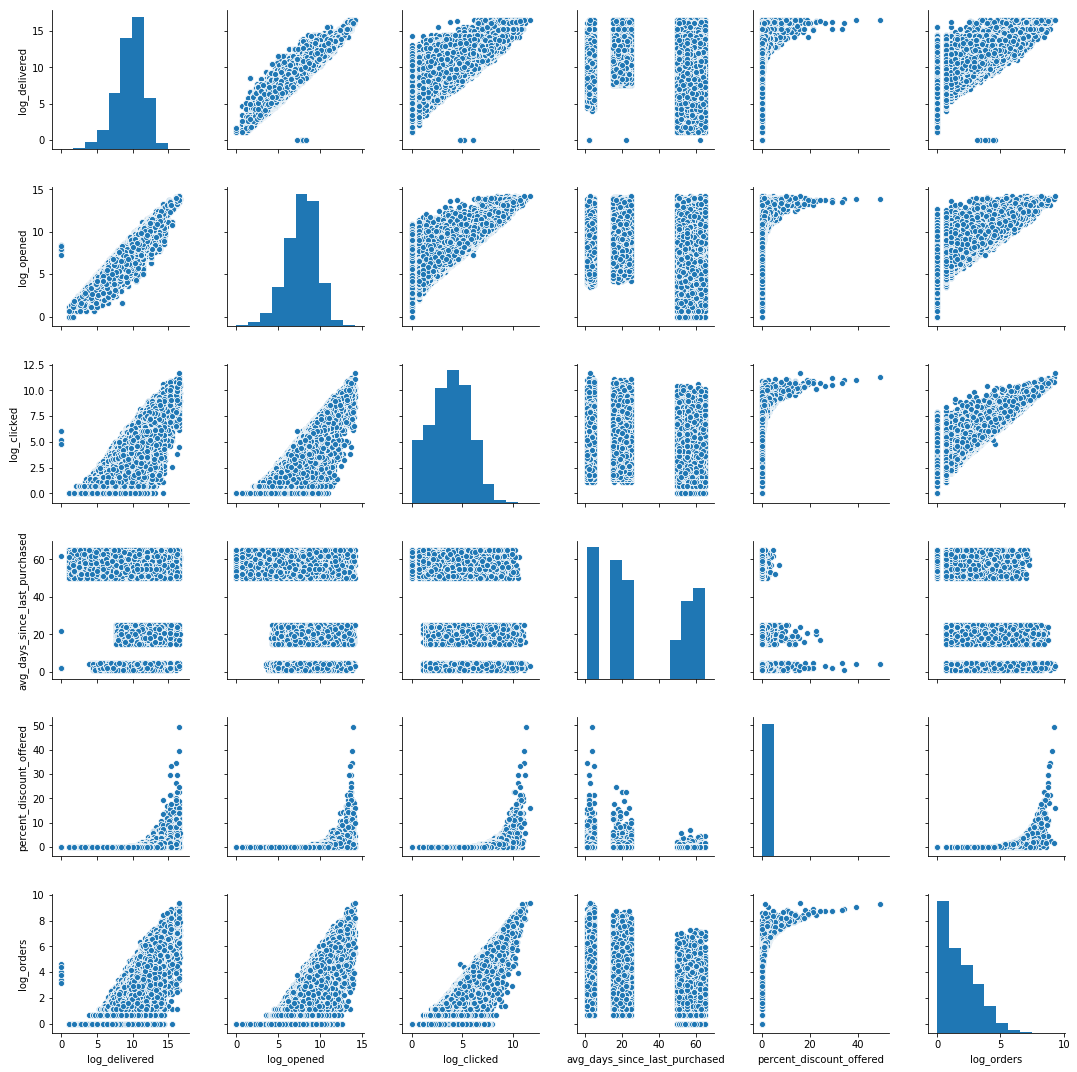

In [12]:
#update numerical_vars list with transformed variables
numerical_vars = ['log_delivered','log_opened','log_clicked','avg_days_since_last_purchased','percent_discount_offered','log_orders']

plt.figure()
sns.pairplot(df[numerical_vars])
plt.show()

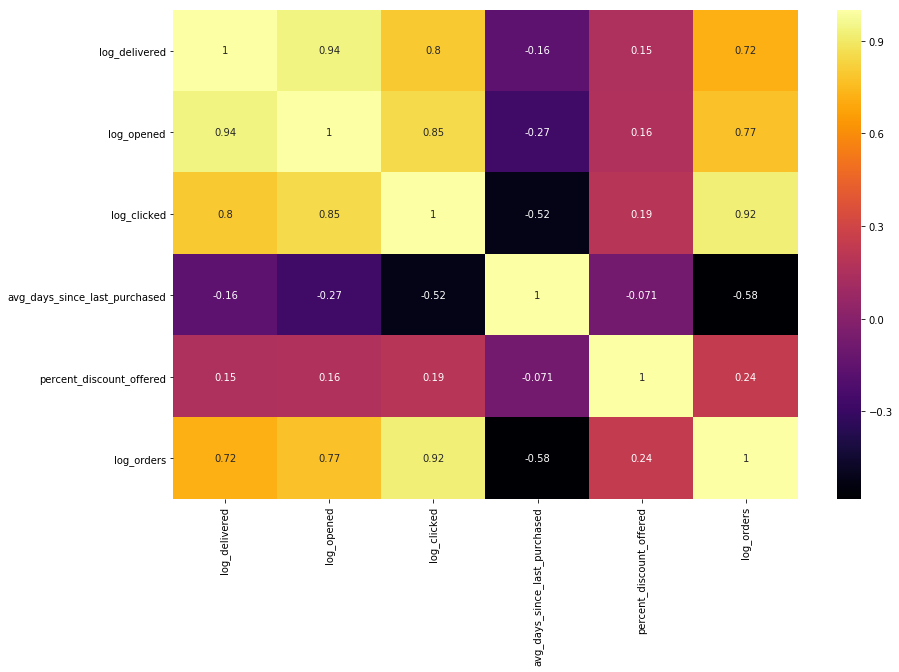

In [13]:
plt.figure(figsize=(14,9))

sns.heatmap(df[numerical_vars].corr(), cmap='inferno', annot=True);

In [14]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#calculate VIF for numerical columns
X = add_constant(df[numerical_vars[:-1]])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

C:\Users\17813\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                            34.508658
log_delivered                     9.669000
log_opened                       11.616052
log_clicked                       5.732540
avg_days_since_last_purchased     1.795201
percent_discount_offered          1.039368
dtype: float64

There is a high correlation between the variables 'delivered', 'opened', and 'clicked'. This is expected because of the description in the data definitions.
<br>
<br>
Looking at the variance inflation factors, 'delivered' and 'opened' have VIFs near or above 10 which signals very high correlation with other variables, and 'clicked' has a VIF of over 5 which is moderately high as well.
<br>
<br>
There are a few approaches to avoid multicollinearity:
- perform PCA
- remove certain predictors to reduce VIFs

I will remove the 'opened' predictor because of its dependence on 'delivered'. I will keep the 'clicked' variable because even though it is somewhat dependent on how many emails are delivered, it will be a strong predictor of number of orders because most people who click the link to buy the product will end up buying the product. I will also drop the 'avg_days_since_last_purchased' because I do not expect that to have much of an impact on the number of orders.

In [15]:
#update numerical_vars list by removing 'log_opened'
numerical_vars = ['log_delivered','log_clicked','percent_discount_offered','log_orders']

#calculate VIF for numerical columns
X = add_constant(df[numerical_vars[:-1]])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                       33.847296
log_delivered                2.759675
log_clicked                  2.797341
percent_discount_offered     1.037824
dtype: float64

The VIFs are now lower. <br>
<br>
I will also assume that I have received notice that the 'percent_discount_offered' variable should all be decimal numbers between 0 and 1. I will divide all of the numbers greater than or equal to 1 by 100.

In [16]:
#divide all values >= 1 by 100 to turn to decimal values < 1
df['percent_discount_offered_cleaned'] = (np.where(df['percent_discount_offered'] >= 1,
                                                   df['percent_discount_offered']/100, 
                                                   df['percent_discount_offered']))

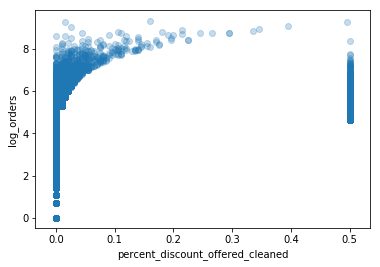

In [17]:
plt.scatter(x='percent_discount_offered_cleaned', y='log_orders', data=df, alpha=.25)
plt.xlabel('percent_discount_offered_cleaned');
plt.ylabel('log_orders');

In [18]:
# #update numerical_vars list
numerical_vars = ['log_delivered','log_clicked','percent_discount_offered_cleaned','log_orders']

Before I use the 'campaign_sent_period', I will use one hot encoding to turn each category into a binary variable.

In [19]:
var = numerical_vars + ['campaign_sent_period']

dummy_cols = ['campaign_sent_period']

df_encoded = pd.get_dummies(df[var], columns=dummy_cols)
df_encoded.head()

,log_delivered,log_clicked,percent_discount_offered_cleaned,log_orders,campaign_sent_period_0,campaign_sent_period_1,campaign_sent_period_2
0,4.262680,0.000000,0.0,0.000000,0,1,0
1,13.293292,7.636270,0.0,4.770685,0,1,0
2,10.114316,3.784190,0.0,1.791759,0,1,0
3,8.125039,3.135494,0.0,1.098612,1,0,0
4,12.706587,7.427144,0.5,5.117994,1,0,0


#### Split the dataset

In [27]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('log_orders', axis=1)
y = df_encoded['log_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [28]:
X_train.head()

,log_delivered,log_clicked,percent_discount_offered_cleaned,campaign_sent_period_0,campaign_sent_period_1,campaign_sent_period_2
141259,7.778630,1.386294,0.0,0,1,0
296658,11.132821,3.583519,0.0,0,0,1
377765,10.584081,3.496508,0.0,0,0,1
438430,10.616119,5.303305,0.0,0,1,0
170168,10.450568,5.420535,0.0,0,1,0


#### Evaluate model
There are multiple ways to evaluate the accuracy of a linear model. A few ways are:
- Mean absolute error
- Root mean squared error<br>

I will use the root mean squared error to evaluate the accuracy of my model because it is an absolute measure of fit. It explains the prediction error of the regression line compared to the actual value.

#### Linear model

In [29]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm_model = lm.fit(X_train, y_train)
log_lm_y_pred = lm.predict(X_test)

print('Coefficients:' , lm_model.coef_, '\nIntercept:', lm_model.intercept_)

Coefficients: [ 2.99977976e-02  6.21353780e-01  1.93893940e+00  2.40320764e-01
 -1.73814268e-03 -2.38582621e-01] 
Intercept: -0.931945276684427


#### XGBoost

In [23]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', booster='gblinear', n_estimators=100)
xgb_model = xg_reg.fit(X_train,y_train)
log_xgb_y_pred = xg_reg.predict(X_test)

print('Coefficients:' , xgb_model.coef_, '\nIntercept:', xgb_model.intercept_)

C:\Users\17813\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\17813\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Coefficients: [ 0.0572614  0.592008   1.96686   -0.272101  -0.536295  -0.795181 ] 
Intercept: [-1.05086]


In [31]:
#back transform the log transformed columns
lm_y_pred = np.expm1(log_lm_y_pred)
xgb_y_pred = np.expm1(log_xgb_y_pred)
y_test = np.expm1(y_test)

#### Model accuracy

In [25]:
from sklearn.metrics import mean_squared_error

lm_RMSE = np.sqrt(mean_squared_error(y_test, lm_y_pred))
xgb_RMSE = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print('LM RMSE:', lm_RMSE, '\nXGB RMSE:', xgb_RMSE)

LM RMSE: 79.06442323419222 
XGB RMSE: 79.26446880101935


In [32]:
from sklearn.metrics import r2_score

r2_score(y_test, lm_y_pred)

0.3538554635096074

#### Interpretation
The linear regression model using sklearn and xgb have similar RMSE values. I will use the sklearn linear regression model because it has a slightly higher RMSE. The model's prediction can be interpreted as having a deviance of about 79 orders from the actual orders.<br>
<br>
The equation for the regression model is:<br>
log_orders = 0.0299977976(log_delivered) + 0.621353780(log_clicked) + 1.93893940(percent_discount_offered_cleaned) + 0.240320764(campaign_sent_period_0) - 0.00173814268(campaign_sent_period_1) - 0.238582621(campaign_sent_period_2) - 0.931945276684427

Interpretation:
- log_delivered: a 10% in emails delivered would increase orders by 0.2%
- log_clicked: a 10% increase in email clicks would increase orders by 6%
- percent_discount_offered_cleaned: for a one-unit (10%) increase in percent_discount_offered_cleaned, orders will increase by about 60%
- campaign_sent_period_0 (morning): campaigns sent at period 0 increase the amount of orders by about 27%
- campaign_sent_period_1 (afternoon): campaigns sent at period 1 reduce the amount of orders by about .1%
- campaign_sent_period_2 (evening): campaigns sent at period 2 reduce the amount of orders by about 21%

These values were calculated by taking the np.expm1(x) of each of the non log tranformed coefficients x, and by taking (1.10)**(x) for each log transformed coefficients x.